In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from category_encoders import BinaryEncoder
%matplotlib inline
df = pd.read_csv("./data/loan_dataset.csv")
df.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [2]:
# bad_loan : 1 when load not paid, 0 good loan

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_inc             20000 non-null  float64
 3   short_emp              20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   dti                    19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

In [4]:
df.describe(include=[np.object_])

,grade,home_ownership,purpose,term
count,20000,18509,20000,20000
unique,7,3,12,3
top,B,MORTGAGE,debt_consolidation,36 months
freq,6042,9844,12337,14969


In [5]:
df.describe().round(2)

,id,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,20000.00,20000.00,20000.00,20000.00,19846.00,20000.00,574.00,20000.00,20000.00,20000.00,20000.0
mean,7590662.08,73349.58,0.11,6.82,16.59,0.55,0.76,55.96,0.29,0.50,0.2
std,1609593.30,45198.57,0.32,3.77,7.59,0.50,0.43,42.12,3.11,0.29,0.4
min,586040.00,8412.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
25%,6206282.75,47000.00,0.00,3.00,10.85,0.00,1.00,38.80,0.00,0.26,0.0
50%,7378896.50,65000.00,0.00,7.00,16.19,1.00,1.00,57.10,0.00,0.51,0.0
75%,8766234.75,88000.00,0.00,11.00,22.06,1.00,1.00,73.90,0.00,0.75,0.0
max,11454641.00,1000000.00,1.00,11.00,34.99,1.00,1.00,5010.00,96.47,1.00,1.0


### Initial analyses:

- mean of the total bad_loans is 0.2, hence most borrowers don't default on their loans
- Annual_inc, revol_util and total_rec_late_fee have outliers in the data


In [6]:
df.isnull().sum()

id                           0
grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64

A vast majority of last_major_derog_none values are missing, hence we will drop that column

In [7]:
df.drop(["id", "last_major_derog_none"], axis=1, inplace=True)

In [8]:
# missing values imputation
df.home_ownership = df.home_ownership.fillna(df.home_ownership.value_counts().index[0])
df.dti = df.dti.fillna(df.dti.mean())

### Numeric distribution

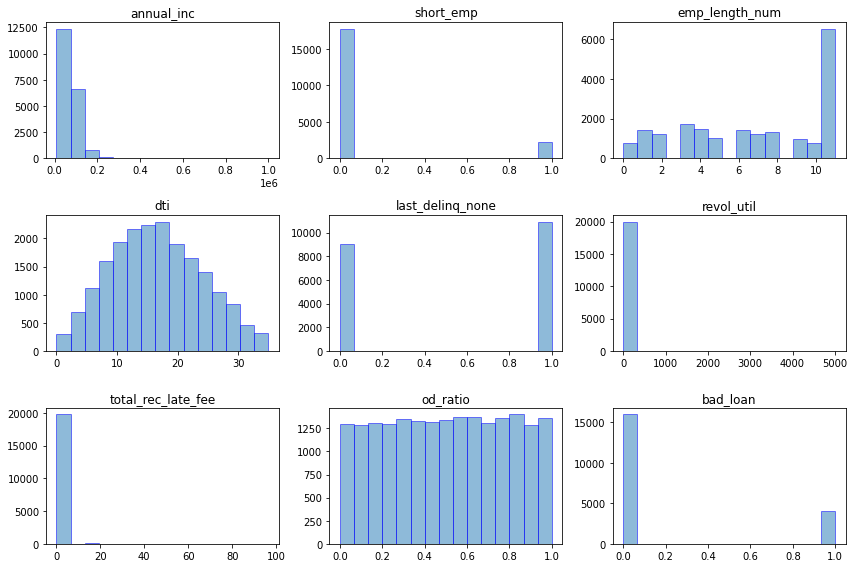

In [9]:
df.hist(figsize=(12, 8), bins=15, grid=False, ec="b", alpha=0.5)
plt.tight_layout()

### Categorical distribution

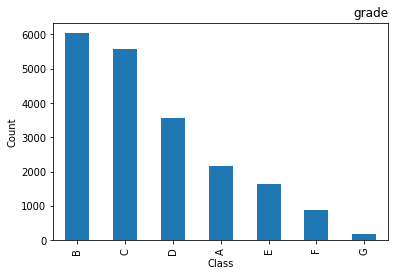

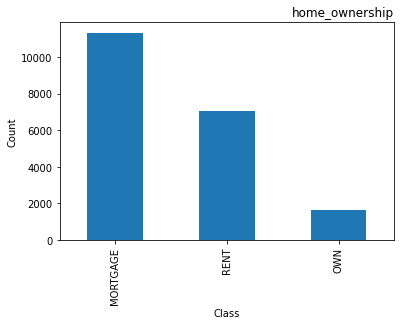

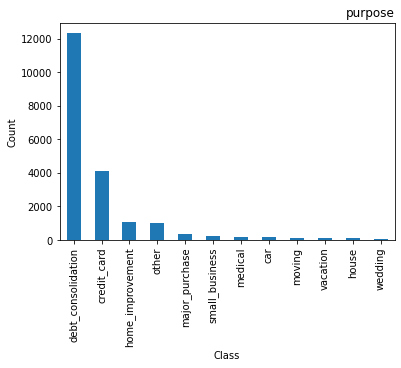

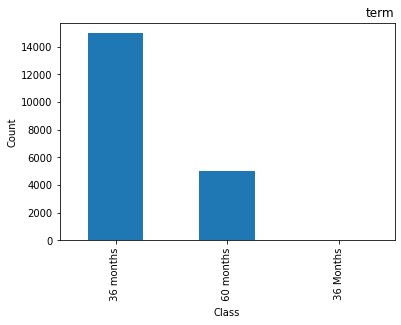

In [10]:
for col in df.select_dtypes(include=["object"]).columns:
    df[col].value_counts().plot(kind="bar")
    plt.xlabel("Class")
    plt.xticks(rotation=90)
    plt.ylabel("Count")
    plt.title(col, loc="right")
    plt.show()

<AxesSubplot:>

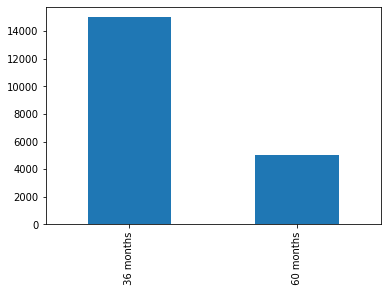

In [11]:
df.term = df.term.str.lower()
df.term.value_counts().plot(kind="bar")

### Feature: Grade

<AxesSubplot:xlabel='grade', ylabel='count'>

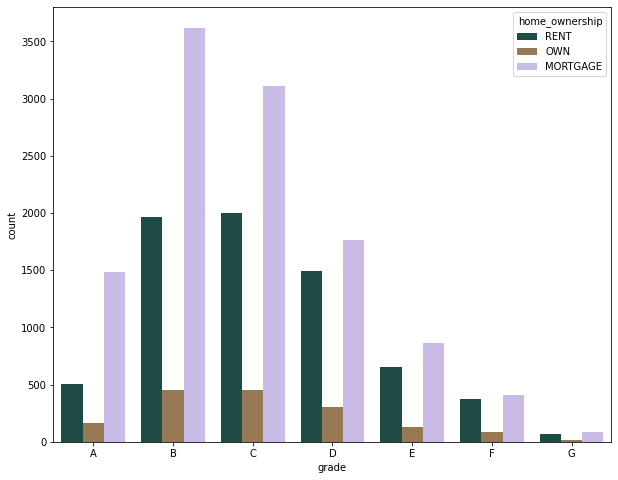

In [12]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.grade.sort_values(), hue=df.home_ownership, data=df, palette="cubehelix")

With lower loan grade classes, tend to have higher concentration of rented houses as compared to mortgage

<AxesSubplot:xlabel='grade', ylabel='count'>

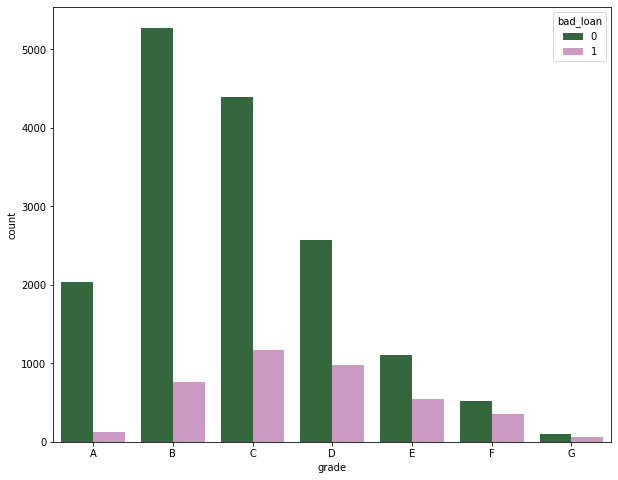

In [13]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.grade.sort_values(), hue=df.bad_loan, data=df, palette="cubehelix")

Grade C has the most defaulted on loans, whereas grade B has the most successful payments

### Feature: Annual Income

<AxesSubplot:xlabel='annual_inc', ylabel='dti'>

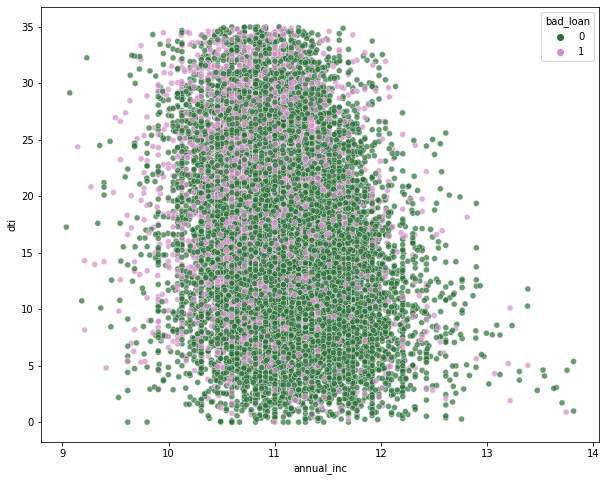

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=np.log(df.annual_inc), y=df.dti, hue=df.bad_loan, palette="cubehelix", alpha=0.7)

In [15]:
df.annual_inc.corr(df.dti)

-0.2294712565713466

### As is evident from the scatterplot and the correlation factor, the greater debt to income ratio tend to default more on their loans

### Borrowers from lower-middle-income class with high debt-to-income ratio tend to default the most

### Feature: Home Ownership

<AxesSubplot:xlabel='home_ownership', ylabel='count'>

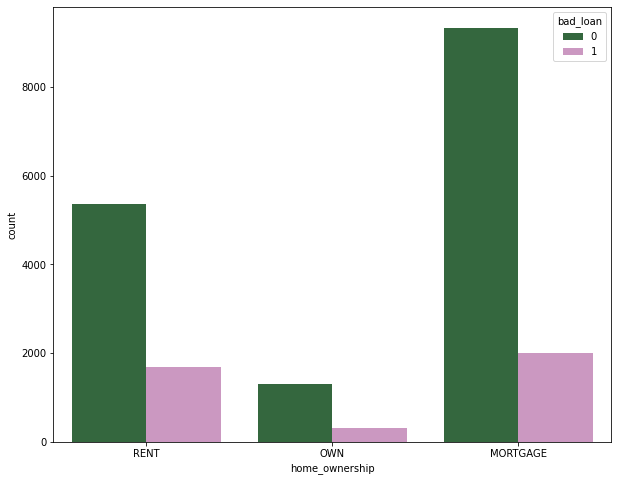

In [16]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.home_ownership, hue=df.bad_loan, data=df, palette="cubehelix")

Relative to their borrowing size, borrowers on rental homes tend to default most on their loans

### Feature: Term

<AxesSubplot:xlabel='term', ylabel='count'>

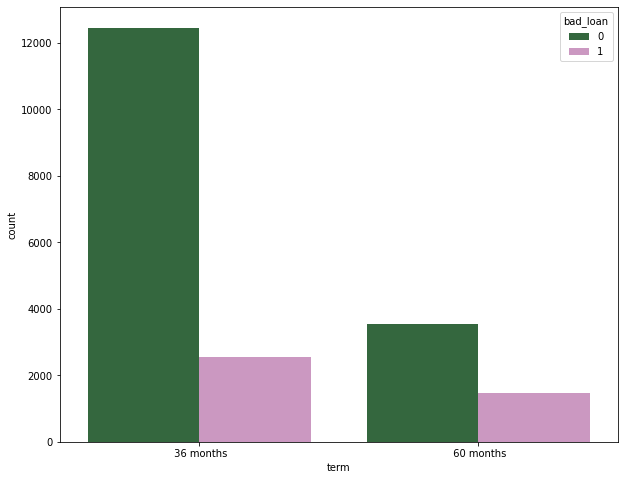

In [17]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.term, hue=df.bad_loan, data=df, palette="cubehelix")

Defaults are much more common in 60 month terms than their 36 month counterpart

<AxesSubplot:xlabel='dti', ylabel='term'>

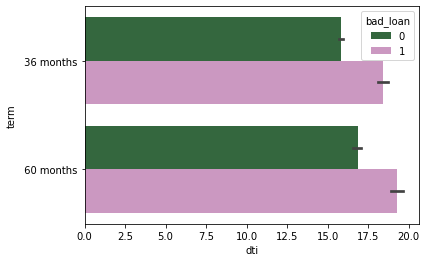

In [18]:
sns.barplot(x=df.dti, y=df.term, hue=df.bad_loan, palette="cubehelix")


### Feature: Last Deliquency

<AxesSubplot:xlabel='last_delinq_none', ylabel='count'>

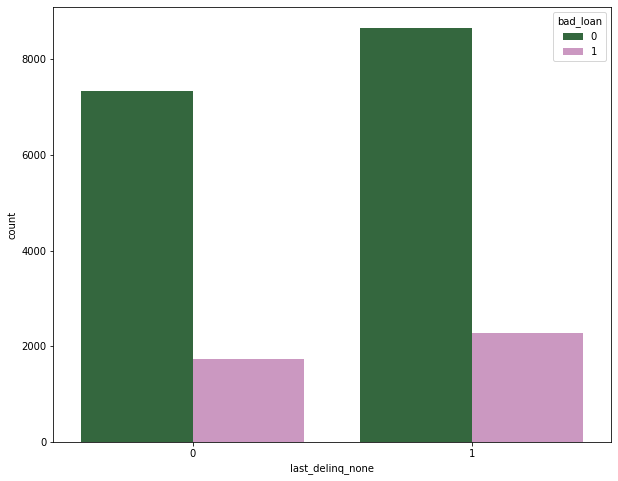

In [19]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.last_delinq_none, hue=df.bad_loan, data=df, palette="cubehelix")

A previous delinquecy doesn't have too great an impact on defaulting probabilities

### Feature: Purpose

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'credit_card'),
  Text(1, 0, 'debt_consolidation'),
  Text(2, 0, 'medical'),
  Text(3, 0, 'other'),
  Text(4, 0, 'home_improvement'),
  Text(5, 0, 'small_business'),
  Text(6, 0, 'major_purchase'),
  Text(7, 0, 'vacation'),
  Text(8, 0, 'car'),
  Text(9, 0, 'house'),
  Text(10, 0, 'moving'),
  Text(11, 0, 'wedding')])

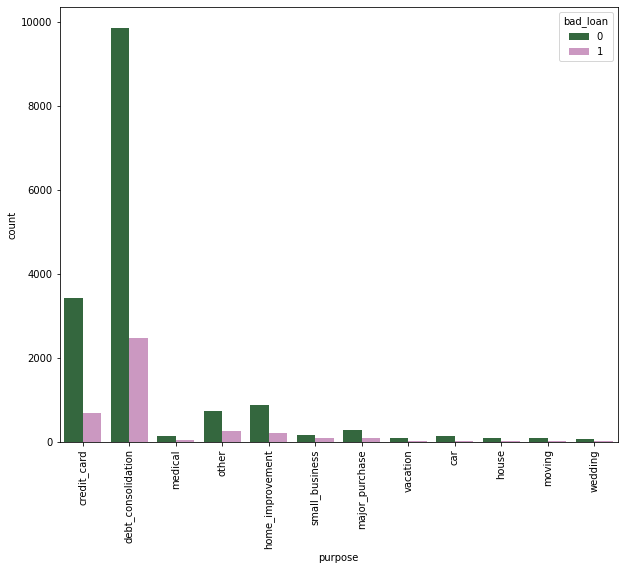

In [20]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.purpose, hue=df.bad_loan, palette="cubehelix")
plt.xticks(rotation=90)

### Debt consolidation and credit cards are by-far the leading purpose why borrowers get loans

For the proportion of borrowers, the default rate is equivalent for for good/bad 90 day rating

### Feature: Revolving line utilization rate

/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='annual_inc', ylabel='revol_util'>

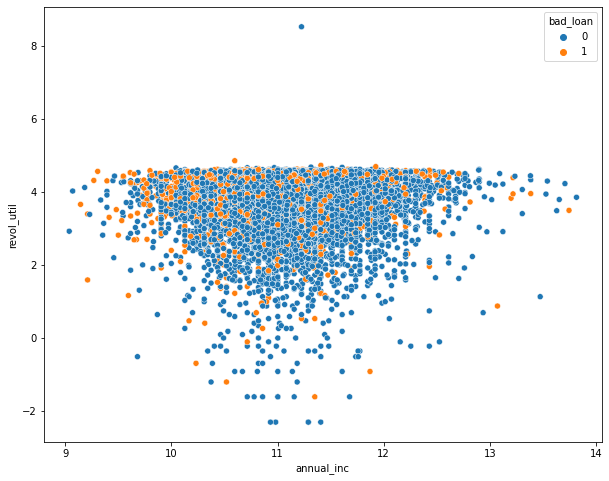

In [21]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=np.log(df.annual_inc), y=np.log(df.revol_util), hue=df.bad_loan)

The lowest income earners have the most late fees 

### Feature: Late fees received to date

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'credit_card'),
  Text(1, 0, 'debt_consolidation'),
  Text(2, 0, 'medical'),
  Text(3, 0, 'other'),
  Text(4, 0, 'home_improvement'),
  Text(5, 0, 'small_business'),
  Text(6, 0, 'major_purchase'),
  Text(7, 0, 'vacation'),
  Text(8, 0, 'car'),
  Text(9, 0, 'house'),
  Text(10, 0, 'moving'),
  Text(11, 0, 'wedding')])

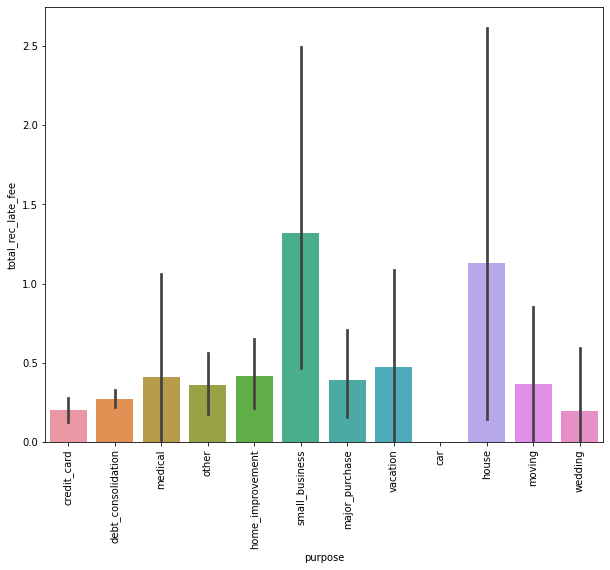

In [22]:
plt.figure(figsize=(10, 8))
sns.barplot(x=df.purpose, y=df.total_rec_late_fee, data=df)
plt.xticks(rotation=90)

Though there's a high variability in the data, most of the late fees are amassed from small businesses and hour loans

<AxesSubplot:>

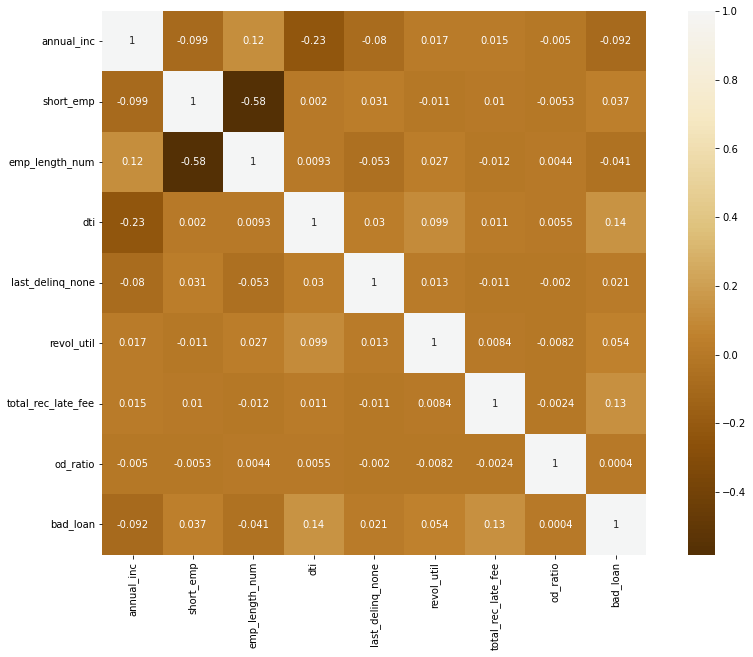

In [23]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='BrBG', center=True, square=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   grade               20000 non-null  object 
 1   annual_inc          20000 non-null  float64
 2   short_emp           20000 non-null  int64  
 3   emp_length_num      20000 non-null  int64  
 4   home_ownership      20000 non-null  object 
 5   dti                 20000 non-null  float64
 6   purpose             20000 non-null  object 
 7   term                20000 non-null  object 
 8   last_delinq_none    20000 non-null  int64  
 9   revol_util          20000 non-null  float64
 10  total_rec_late_fee  20000 non-null  float64
 11  od_ratio            20000 non-null  float64
 12  bad_loan            20000 non-null  int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 2.0+ MB


In [25]:
# numerical features
X_num = df.select_dtypes(exclude="object").copy(deep=True)
y_num = X_num.bad_loan

X_num.drop('bad_loan', axis=1, inplace=True)

# categorical features
X_cat = df[['grade', 'purpose', 'home_ownership', 'term', 'bad_loan']].copy(deep=True)
y_cat = X_cat.bad_loan

X_cat.drop('bad_loan', axis=1, inplace=True)

### Chi-square test for independence

In [26]:
for col in X_cat.columns:
    table = pd.crosstab(X_cat[col], y_cat)
    print()
    display(table)
    _, pval, _, expected_table = scipy.stats.chi2_contingency(table)
    print(f"p-value: {pval:.25f}")

bad_loan,0,1
grade,,
A,2035,124
B,5275,767
C,4394,1172
D,2575,979
E,1103,542
F,514,351
G,104,65


p-value: 0.0000000000000000000000000



bad_loan,0,1
purpose,,
car,138,30
credit_card,3435,702
debt_consolidation,9855,2482
home_improvement,887,209
house,86,15
major_purchase,293,86
medical,136,39
moving,93,30
other,747,274


p-value: 0.0000000000000162515310082



bad_loan,0,1
home_ownership,,
MORTGAGE,9335,2000
OWN,1297,316
RENT,5368,1684


p-value: 0.0000000000000000000000105



bad_loan,0,1
term,,
36 months,12462,2539
60 months,3538,1461


p-value: 0.0000000000000000000000000


since all p-values are less than 0.5, we rejct the null hypothesis and establish that features have a relationship to the target


### next 
-  One-hot & binary encoding-
- Transformation of factor levels for categorical data

In [27]:
# create a mapping for grades
grade_mapping = {"A":7, "B":6, "C":5, "D":4, "E":3, "F":2, "G":1}

df['grade_CAT'] = df.grade.map(grade_mapping)


# get ohe dummies for columns
term_ohe = pd.get_dummies(df.term)
grade_ohe = pd.get_dummies(df.grade_CAT)
purpose_ohe = pd.get_dummies(df.purpose)
homeOwnership_ohe = pd.get_dummies(df.home_ownership)

df.head()

,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_CAT
0,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,43.2,0.0,0.160624,0,7
1,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,21.5,0.0,0.810777,0,7
2,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,46.3,0.0,0.035147,1,4
3,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,10.7,0.0,0.534887,1,4
4,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,15.2,0.0,0.166500,0,4


In [28]:
# concat dataset with ohe data
df_with_ohe = pd.concat([df, term_ohe, grade_ohe, purpose_ohe, homeOwnership_ohe], axis=1)
# drop repeated columns
df_with_ohe.drop(['grade', 'grade_CAT', 'term', 'purpose', 'home_ownership'], axis=1, inplace=True)
df_with_ohe.head()

,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan,36 months,...,major_purchase,medical,moving,other,small_business,vacation,wedding,MORTGAGE,OWN,RENT
0,100000.0,1,1,26.27,1,43.2,0.0,0.160624,0,1,...,0,0,0,0,0,0,0,0,0,1
1,83000.0,0,4,5.39,0,21.5,0.0,0.810777,0,1,...,0,0,0,0,0,0,0,0,1,0
2,78000.0,0,11,18.45,1,46.3,0.0,0.035147,1,0,...,0,0,0,0,0,0,0,1,0,0
3,37536.0,0,6,12.28,0,10.7,0.0,0.534887,1,0,...,0,1,0,0,0,0,0,1,0,0
4,65000.0,0,11,11.26,0,15.2,0.0,0.166500,0,1,...,0,0,0,0,0,0,0,1,0,0


### Predictive Models